In [1]:
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
import os
from os.path import exists

from export_netCDF import export_netCDF

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

import copy
import utilities
from reinitializelevelset import *

In [2]:
# Setup
cluster_username = 'mpascual'


In [10]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.1.nc')

###################################
## set the inversion parameters ##
###################################
## Inversion
print('Setting up the inversion')
# Control general
md.inversion=m1qn3inversion(md.inversion)
md.inversion.iscontrol=1
md.verbose.solution = False
md.verbose.control = True
md.verbose.qmu = False

# Cost functions
print(' -> Setting cost function values')
md.inversion.cost_functions=[101, 103, 501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)])
md.inversion.cost_functions_coefficients[:,0]=2000
md.inversion.cost_functions_coefficients[:,1]=40
md.inversion.cost_functions_coefficients[:,2]=1.6e-06

# Where vel==0, set coefficients to 0 (i.e., don't try to match this in model)
print(' -> Removing vel==0 obs from inversion')
pos = md.inversion.vel_obs == 0
md.inversion.cost_functions_coefficients[pos,0] = 0
md.inversion.cost_functions_coefficients[pos,1] = 0

# Controls
print(' -> Setting control parameters')
md.inversion.control_parameters=['FrictionCoefficient']
md.inversion.maxsteps=50
md.inversion.maxiter =100
md.inversion.min_parameters=0.05*np.ones(md.mesh.numberofvertices)
md.inversion.max_parameters=np.nan*np.ones(md.mesh.numberofvertices)
md.inversion.control_scaling_factors=1

# Additional parameters
md.stressbalance.restol=0.01
md.stressbalance.reltol=0.1
md.stressbalance.abstol=np.nan
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

md.friction.coupling = 2

print('')

    
#set ice rheology
from cuffey import cuffey 
#Vary Celsius range with LHS
temperature = -10 + (-10*0.5) #(-15 = cold, -1 = warm)
# convert celsius to kelvin
temperature = temperature + 273.15 
#Calculate rigidity
rigidity = cuffey(temperature)
#Set rigidity calculation to rheology
md.materials.rheology_B = rigidity
    
####################
## run inversion ##
####################
# SMCE pCluster
from eis_nasa_smce import eis_nasa_smce
md.cluster = eis_nasa_smce()
md.cluster.name = 'pcluster.sealevel.eis.smce.nasa.gov'
md.cluster.partition = 'sealevel-c5n18xl-demand'
md.cluster.login = cluster_username
md.cluster.idfile = '~/.ssh/id_rsa'
md.cluster.executionpath = '/efs/' + cluster_username + '/issm_execution_cluster'
md.cluster.numnodes = 1
md.cluster.cpuspernode = 36

md.inversion.iscontrol = 1 
md.settings.waitonlock = np.inf
md = solve(md, 'sb')
    
export_netCDF(md, '/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m0.1.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.1.nc for reading 
group toolkits is empty
empty init
Setting up the inversion


Exception: constructor not supported

In [16]:
md1 = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m1.nc')
md2 = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc')
md_vel_tot = (md1.results.StressbalanceSolution.Vel - md2.results.StressbalanceSolution.Vel)

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m1.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init
Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init


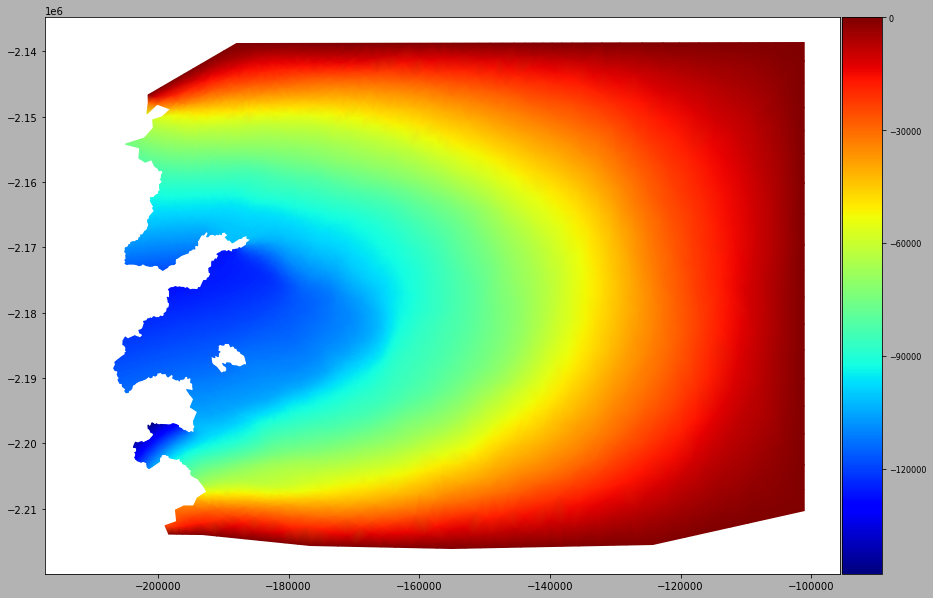

In [10]:
fig = plt.figure(figsize=(15,15))
plotmodel(md1, 'data', md_vel_tot, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet')


In [3]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.1.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.1.nc for reading 
group toolkits is empty
empty init


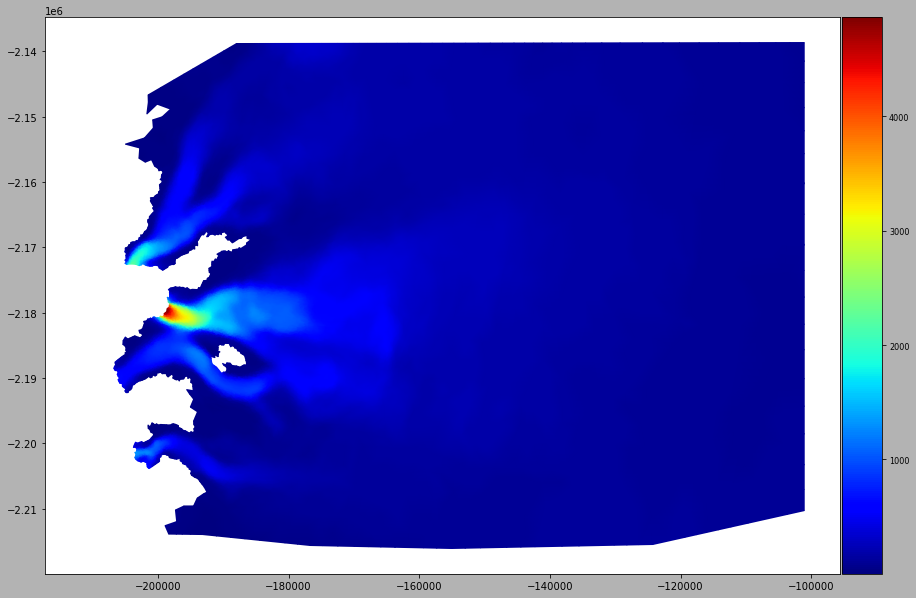

In [4]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.results.StressbalanceSolution.Vel, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet')

In [7]:
md.materials

   Materials:
         rho_ice                : 917             -- ice density [kg/m^3]
         rho_water              : 1023            -- water density [kg/m^3]
         rho_freshwater         : 1000            -- fresh water density [kg/m^3]
         mu_water               : 0.001787        -- water viscosity [Ns/m^2]
         heatcapacity           : 2093            -- heat capacity [J/kg/K]
         thermalconductivity    : 2.4             -- ice thermal conductivity [W/m/K]
         temperateiceconducti...: 0.24            -- temperate ice thermal conductivity [W/m/K]
         effectiveconductivit...: 1               -- computation of effectiveconductivity: (0) arithmetic mean, (1) harmonic mean, (2) geometric mean (default)
         meltingpoint           : 273.15          -- melting point of ice at 1atm in K
         latentheat             : 334000          -- latent heat of fusion [J/m^3]
         beta                   : 9.8e-08         -- rate of change of melting point wit

In [11]:
md.friction

Basal shear stress parameters: Sigma_b = coefficient^2 * Neff ^r * |u_b|^(s - 1) * u_b,
(effective stress Neff = rho_ice * g * thickness + rho_water * g * base, r = q / p and s = 1 / p)
         coefficient            : (12112,)        -- friction coefficient [SI]
         p                      : (24063,)        -- p exponent
         q                      : (24063,)        -- q exponent
         coupling               : 2               -- Coupling flag 0: uniform sheet (negative pressure ok, default), 1: ice pressure only, 2: water pressure assuming uniform sheet (no negative pressure), 3: use provided effective_pressure, 4: used coupled model (not implemented yet)
         effective_pressure     : N/A             -- Effective Pressure for the forcing if not coupled [Pa]
         effective_pressure_l...: 0               -- Neff do not allow to fall below a certain limit: effective_pressure_limit * rho_ice * g * thickness (default 0)

In [21]:
N = (md.materials.rho_ice * md.geometry.thickness * md.constants.g) - (md.materials.rho_water * md.constants.g * (-md.geometry.bed))
taub = (md.friction.coefficient ** 2) * N * (md.results.StressbalanceSolution.Vel / md.constants.yts) ** (0.1)


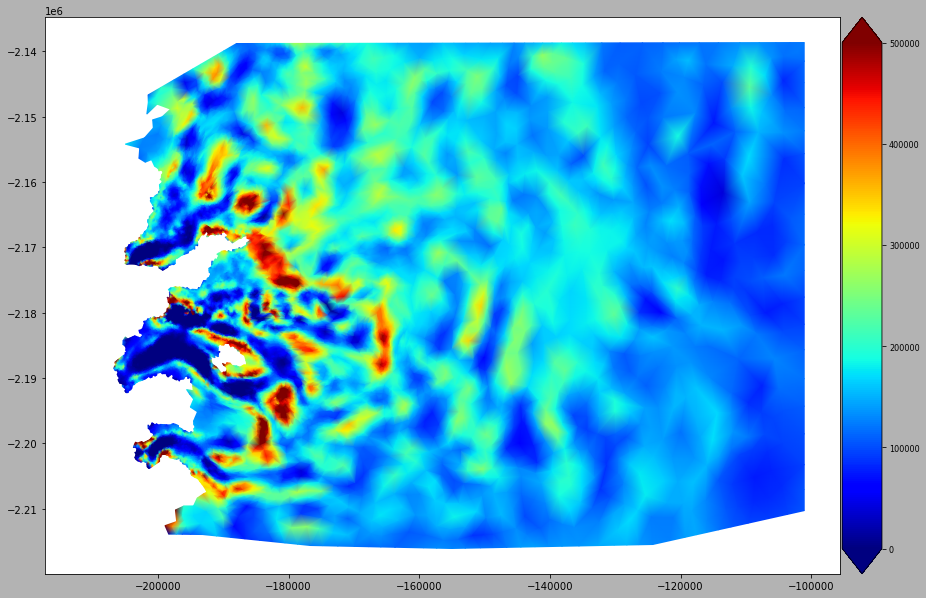

In [22]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', taub, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet', 'caxis', [0, 5e5])

In [23]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.2.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.2.nc for reading 
group toolkits is empty
empty init


In [30]:
N = (md.materials.rho_ice * md.geometry.thickness * md.constants.g) - (md.materials.rho_water * md.constants.g * (-md.geometry.bed))
taub = (md.friction.coefficient ** 2) * N * (md.results.StressbalanceSolution.Vel / md.constants.yts) ** (1/md.friction.p[0])

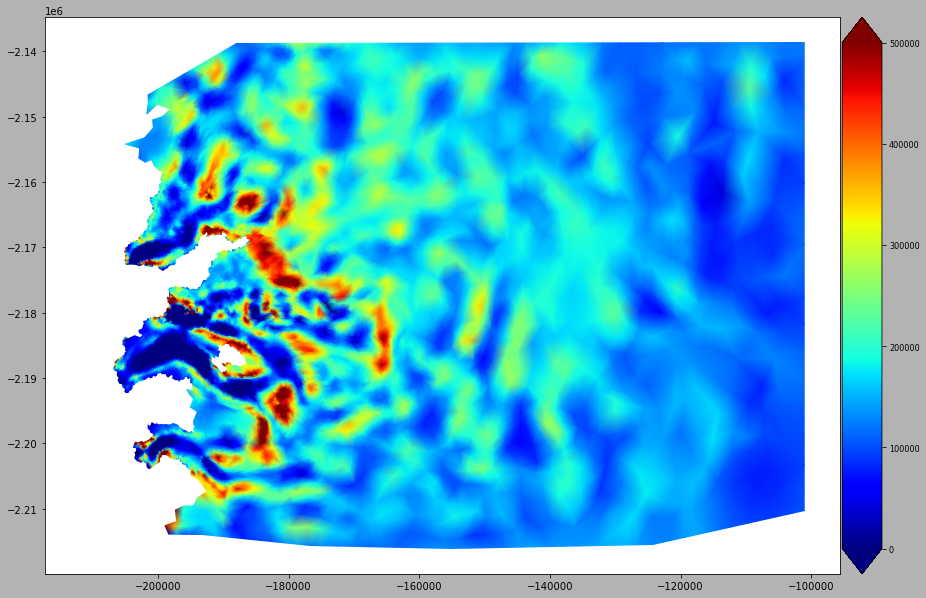

In [31]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', taub, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet', 'caxis', [0, 5e5])

In [32]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.5.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Friction_m0.5.nc for reading 
group toolkits is empty
empty init


In [33]:
N = (md.materials.rho_ice * md.geometry.thickness * md.constants.g) - (md.materials.rho_water * md.constants.g * (-md.geometry.bed))
taub = (md.friction.coefficient ** 2) * N * (md.results.StressbalanceSolution.Vel / md.constants.yts) ** (1/md.friction.p[0])

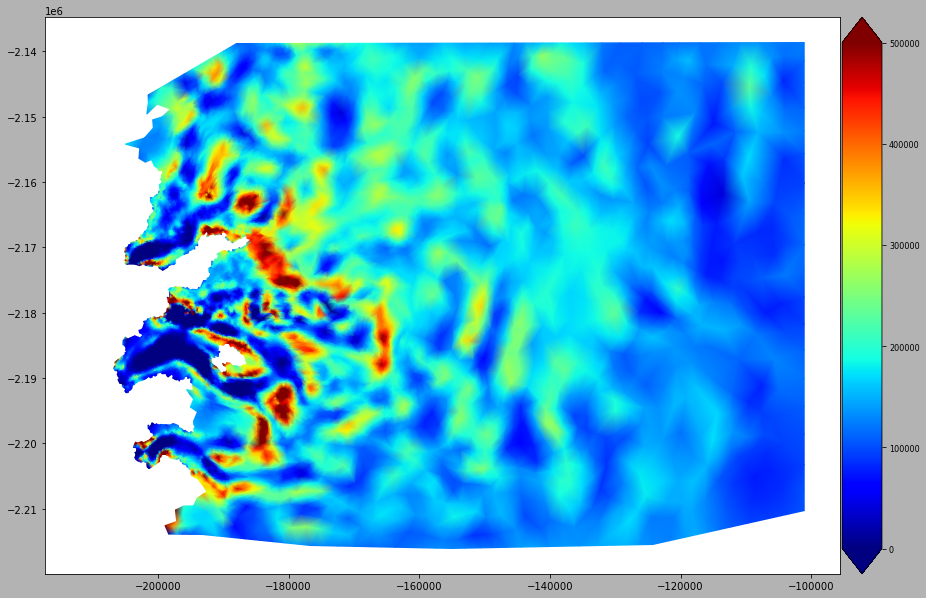

In [34]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', taub, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet', 'caxis', [0, 5e5])

In [36]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Inversion_m1.0.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Inversion_m1.0.nc for reading 
group toolkits is empty
empty init


In [39]:
N = (md.materials.rho_ice * md.geometry.thickness * md.constants.g) - (md.materials.rho_water * md.constants.g * (-md.geometry.bed))
# for m = 1.0, after inversion need to take inversion results and assign to md.friction.coefficient
taub = (md.results.StressbalanceSolution.FrictionCoefficient ** 2) * N * (md.results.StressbalanceSolution.Vel / md.constants.yts) ** (1/md.friction.p[0])

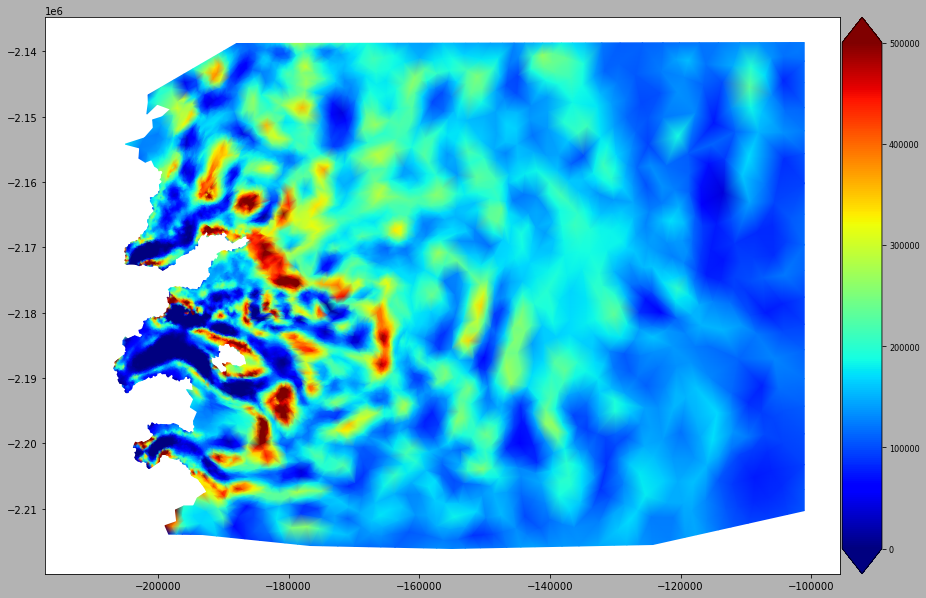

In [40]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', taub, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet', 'caxis', [0, 5e5])